In [2]:
#!pip install scikit-learn
#!pip install tensorflow
#!pip install scikit-image
#!pip install seaborn
#!pip install keras_tuner

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [4]:
# Perceptron import
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.linear_model import Perceptron
from matplotlib.colors import ListedColormap
from sklearn.neural_network import MLPClassifier # neural network

In [5]:
from PIL import Image

## Setting Working Directory

In [6]:
#current working directory
cur_wd = os.getcwd()
print(cur_wd)


/work/MLDL_Exam


In [7]:
#our images are stored in two seperate folders:
os.listdir(os.path.join(cur_wd, 'archive'))

['.DS_Store', 'test', 'train']

In [8]:
#inside each folder of images are further two subfolders dividing the pictures
os.listdir(os.path.join(cur_wd, 'archive', 'test'))

['Benign', 'Malignant', '.DS_Store']

In [9]:
# Define the paths to your training and testing directories
train_dir = './archive/train/'
test_dir = './archive/test/'

In [10]:
#Values
IMG_HEIGHT = 224
IMG_WIDTH = 224
COLOR_CHANNELS = 3

## Loading the Data

In [11]:
from tqdm import tqdm
import numpy as np

def load_images(directory, target_size=(IMG_HEIGHT, IMG_WIDTH)):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        directory,
        target_size=target_size,
        batch_size=32,
        color_mode='rgb',  # Specifies images are to be loaded in RGB mode
        class_mode='binary',  # Adjust based on your needs ('binary' for binary classification)
        shuffle=False  # Important if maintaining order is necessary
    )
    
    num_images = generator.samples
    data = np.zeros((num_images, target_size[0], target_size[1], 3))  # Keeping the images in 3D
    labels = np.zeros((num_images,))
    i = 0
    
    for x_batch, y_batch in generator:
        batch_size = x_batch.shape[0]
        for j in range(batch_size):
            # Store each image as a 3D array
            data[i] = x_batch[j]
            labels[i] = y_batch[j]
            i += 1
        if i >= num_images:
            break
    
    return data, labels


In [12]:
#Loading of the images
X_train, y_train = load_images(train_dir)
X_test, y_test = load_images(test_dir)

Found 11879 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


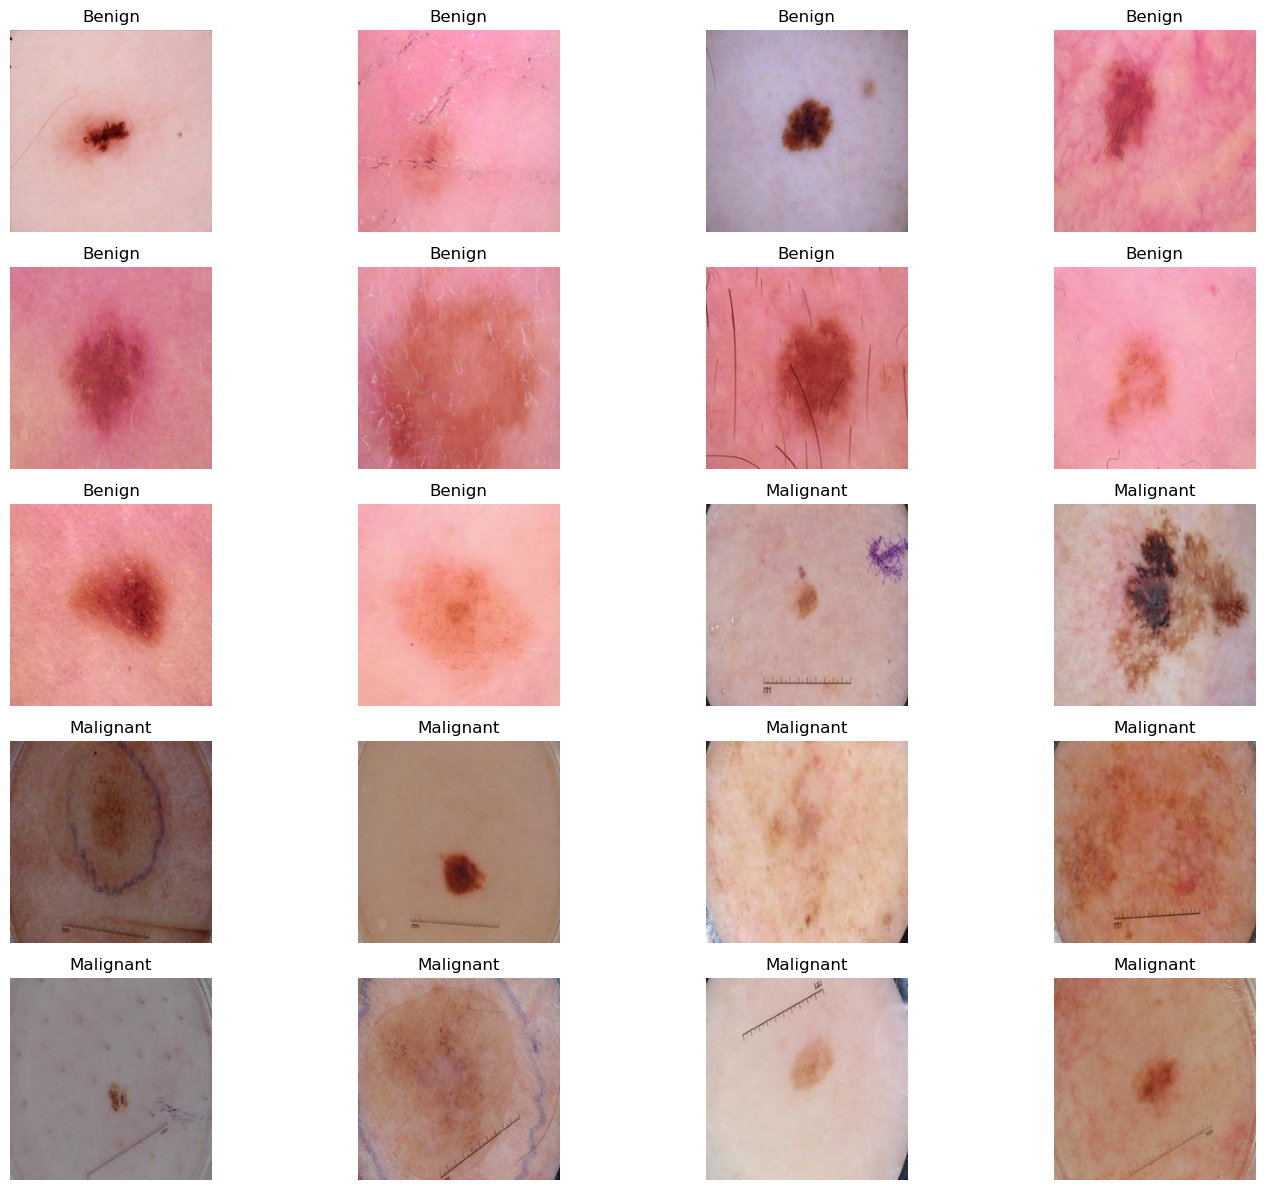

In [13]:
# Reshape images back to 224x224x3
X_train_reshaped = X_train.reshape((-1, IMG_HEIGHT, IMG_WIDTH, COLOR_CHANNELS))

# Selecting 10 benign (first 10) and 10 malignant (from the rest)
benign_images = X_train_reshaped[:10]  # First 10 benign images
malignant_images = X_train_reshaped[-10:]  # Last 10 malignant images

# Combining selected images
selected_images = np.vstack([benign_images, malignant_images])

# Create labels corresponding to the selected images
labels = ['Benign']*10 + ['Malignant']*10  

# Plotting
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(selected_images[i])  
    ax.set_title(labels[i])  # Adding the label as title to each subplot
    ax.axis('off')  # Turn off axis numbering
plt.tight_layout()
plt.show()


In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(11879, 224, 224, 3)
(11879,)
(2000, 224, 224, 3)
(2000,)


In [15]:
def check_images(directory):
    first_file_type = None
    image_sizes = set()

    #we want to iterate through each file in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        try:
            with Image.open(file_path) as img:
                if first_file_type is None:
                    first_file_type = img.format
                elif first_file_type != img.format:
                    print(f"Mixed file types found. {img.format} differs from {first_file_type}")

            image_sizes.add(img.size)

        except IOError:
            print(f"file is not an image or can not be opened {filename}")

    print("Unique image sizes", image_sizes, " file type: ", first_file_type)

In [16]:
check_images('archive/train/Benign')
check_images('archive/train/Malignant')
check_images('archive/test/Benign')
check_images('archive/test/Malignant')

Unique image sizes {(224, 224)}  file type:  JPEG
Unique image sizes {(224, 224)}  file type:  JPEG
Unique image sizes {(224, 224)}  file type:  JPEG
Unique image sizes {(224, 224)}  file type:  JPEG


In [17]:
def balance(y):
    benign_count = np.count_nonzero(y == 0)
    malignant_count = np.count_nonzero(y == 1)

    cat = ['Benign', 'Malignant']
    counts = [benign_count, malignant_count]
    total = sum(counts)

    plt.figure(figsize = (8, 5))
    bars = plt.bar(cat, counts, color = ['green', 'red'])
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Benign and Malignant Images')

    #adding pct to bars:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval/total: .2%}',
            va = 'bottom',
            ha = 'center')

    plt.show()

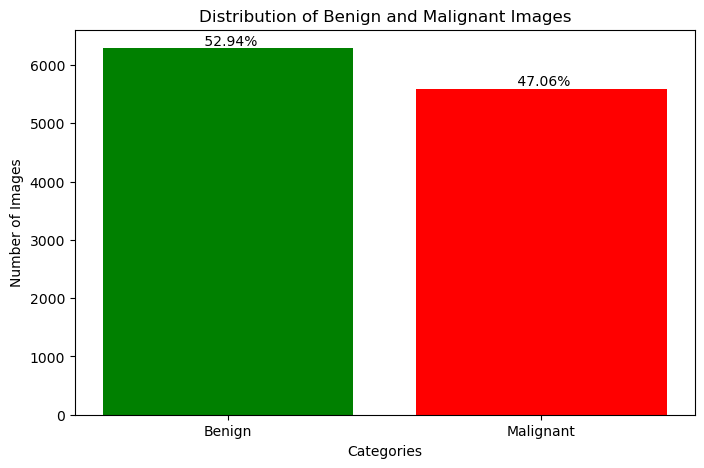

In [18]:
balance(y_train)

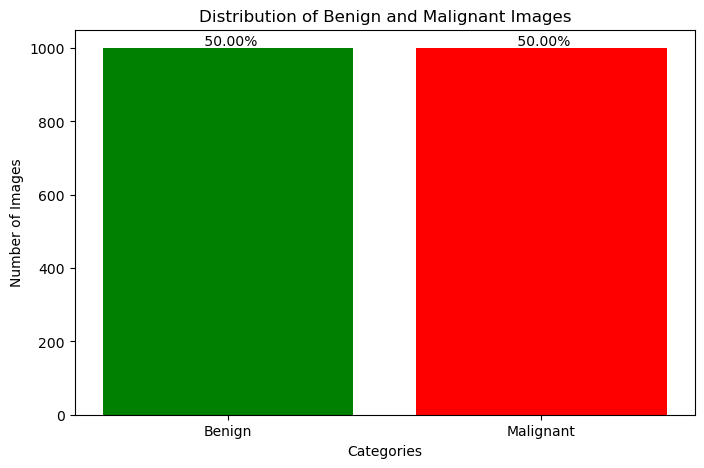

In [19]:
balance(y_test)

## Augmenting our Training Data

In [20]:
# Create an instance of ImageDataGenerator with desired augmentations
train_datagen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=[0.9,1.1],
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7,1.3],
    channel_shift_range=0.1,
    fill_mode='nearest'
)

# Create directory structure if not exists
augmented_train_dir = './archive/augmented_train/'  
class_names = ['Benign', 'Malignant']
for cls in class_names:
    os.makedirs(os.path.join(augmented_train_dir, cls), exist_ok=True)

def augment_images(class_name, num_samples):
    source_dir = os.path.join(train_dir, class_name)
    target_dir = os.path.join(augmented_train_dir, class_name)
    
    # Create a generator for the images
    generator = train_datagen.flow_from_directory(
        train_dir,
        classes=[class_name],
        target_size=(224, 224),  # Adjust size to your requirement
        batch_size=32,
        class_mode='binary',  # Adjust based on your use case
        save_to_dir=target_dir,
        save_prefix='aug',
        save_format='jpg'
    )
    
    # Generate augmented images
    for i in range(num_samples):
        next(generator)

# Number of samples you want to augment per class
num_samples = 90  # Adjust this number based on your needs

# Augment images for each class
for class_name in class_names:
    augment_images(class_name, num_samples)

Found 6289 images belonging to 1 classes.
Found 5590 images belonging to 1 classes.


In [21]:
X_train_aug, y_train_aug = load_images(augmented_train_dir)
len(X_train_aug)

Found 5760 images belonging to 2 classes.


5760

In [22]:
X_train = np.vstack((X_train, X_train_aug))
y_train = np.concatenate((y_train, y_train_aug))

In [23]:
X_train.shape[0]

17639

In [24]:
#shuffling our data:
np.random.seed(64)
indices_train = np.arange(X_train.shape[0])
np.random.shuffle(indices_train)

X_train = X_train[indices_train]
y_train = y_train[indices_train]


np.random.seed(42)
indices_test = np.arange(X_test.shape[0])
np.random.shuffle(indices_test)

X_test = X_test[indices_test]
y_test = y_test[indices_test]

## PCA

In [14]:
from sklearn.decomposition import PCA

data, labels = load_images(train_dir)

# Apply PCA
pca = PCA(n_components=0.95)  # for example, retain 50 components
principal_components = pca.fit_transform(data)

# Explained variance can help determine the number of components to retain
print("Explained variance ratio:", pca.explained_variance_ratio_.sum())

Found 11879 images belonging to 2 classes.


Loading images: 100%|██████████| 11879/11879 [00:15<00:00, 791.60images/s]


Explained variance ratio: 0.9500694951940353


In [15]:
reconstructed_images = pca.inverse_transform(principal_components)

In [23]:
print("Shape of principal components:", principal_components.shape)
print("Shape of reconstructed images:", reconstructed_images.shape)


NameError: name 'principal_components' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


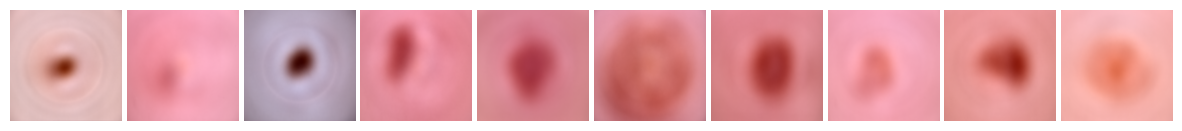

In [17]:
# Reshape the inverse-transformed data (reconstructed images) back to its original dimensions
reconstructed_images_reshaped = reconstructed_images.reshape(-1, IMG_WIDTH, IMG_HEIGHT, COLOR_CHANNELS)

# Number of images to display
num_images_to_display = 10

# Plotting
fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 3))  # Adjusting size for better view

for i in range(num_images_to_display):
    # Display original images
    ax = axes[0, i]  # First row for original images
    ax.imshow(X_train_reshaped[i]) 
    ax.set_title("Original")
    ax.axis('off')  # Turn off axis numbering
    
    # Display reconstructed images
    ax = axes[1, i]  # Second row for reconstructed images
    ax.imshow(reconstructed_images_reshaped[i].astype('uint8'))
    ax.set_title("Reconstructed")
    ax.axis('off')

plt.subplots_adjust(wspace=0.05, hspace=0.1)  # Adjusting spacing to minimize gaps
plt.show()


In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio by each component:", explained_variance_ratio)

# Cumulative variance explained
cumulative_variance = np.cumsum(explained_variance_ratio)
print("Cumulative variance explained by components:", cumulative_variance)

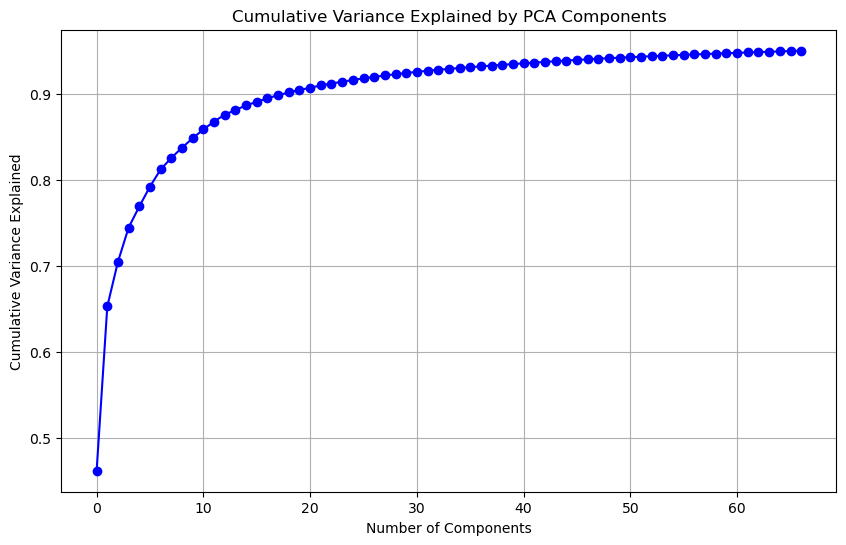

In [19]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='-', color='b')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()

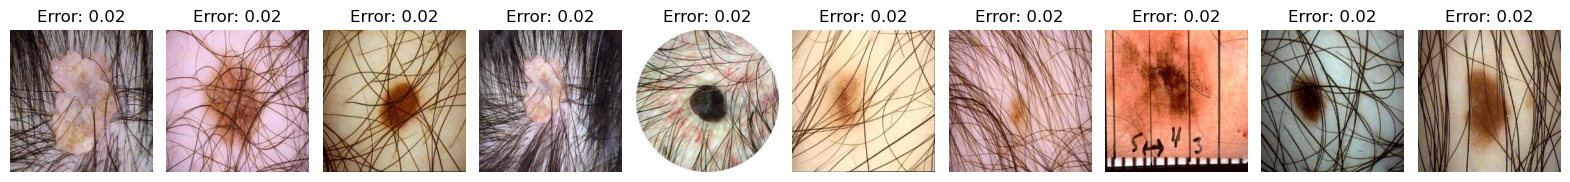

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_high_error_images(original_data, reconstructed_data, target_size=(IMG_HEIGHT, IMG_WIDTH), num_images=10):
    # Calculate reconstruction errors for each image
    errors = np.array([mean_squared_error(original.flatten(), reconstructed.flatten())
                       for original, reconstructed in zip(original_data, reconstructed_data)])
    
    # Find the indices of the images with the highest reconstruction errors
    high_error_indices = np.argsort(errors)[-num_images:]
    
    # Plotting
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i, ax in enumerate(axes):
        # Reshape the image from (150528,) to (224, 224, 3) before plotting
        image_data = original_data[high_error_indices[i]].reshape(target_size[0], target_size[1], 3)
        ax.imshow(image_data)
        ax.set_title(f'Error: {errors[high_error_indices[i]]:.2f}')
        ax.axis('off')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

    return high_error_indices, errors[high_error_indices]

# Example usage:
# Assuming `data` and `reconstructed_data` are your original and PCA-reconstructed datasets, respectively
high_error_indices, high_errors = plot_high_error_images(X_train_reshaped, reconstructed_images_reshaped, num_images=10)


## CNN

In [29]:
from tensorflow.keras.callbacks import TensorBoard
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

log_dir = "logs2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Setup ModelCheckpoint to save the model with the best validation accuracy
checkpoint_callback = ModelCheckpoint(
    'MLDL_Exam/Data/best_model.keras',  # Path where the model is saved
    monitor='val_accuracy',  # Metric to monitor
    save_best_only=True,  # Only save the best model
    save_weights_only=False,  # Save the entire model
    mode='max',  # Save the model with max monitored value
    verbose=1  # Print out messages when saving the model
)

# Setup EarlyStopping to stop training when the validation accuracy stops improving
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    mode='max',
    verbose=1
)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt


def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, COLOR_CHANNELS)))

    # Tuning the number of convolutional layers
    num_layers = hp.Int('num_conv_layers', 3, 5)

    # Starting with a base number of filters
    initial_filters = hp.Int('initial_filters', min_value=32, max_value=64, step=16)
    increase_factor = hp.Choice('increase_factor', [1.0, 2.0, 3.0])  # More granular control over increase

    filters = initial_filters  # Initialize filters to the initial value
    for i in range(num_layers):
        model.add(keras.layers.Conv2D(
            filters=filters,
            kernel_size=hp.Choice(f'kernel_size_{i}', [3, 5]),
            activation='relu',
            padding='same'
        ))
         # Incrementally increase the number of filters based on the layer depth
        # Update filters for the next layer if not the last layer
        if i < num_layers - 1:
            filters = int(filters * increase_factor)
            filters = min(filters, 256)  # Ensure that filters do not exceed 256
        if hp.Choice(f'pooling_{i}', ['max', 'avg']) == 'max':
            model.add(keras.layers.MaxPooling2D(pool_size=2))
        else:
            model.add(keras.layers.AveragePooling2D(pool_size=2))

    model.add(keras.layers.Flatten())

    # Tuning the number of units in the dense layer
    for j in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(keras.layers.Dense(
            units=hp.Int(f'units_{j}', min_value=50, max_value=300, step=50),
            activation='relu'
        ))
        model.add(keras.layers.Dropout(rate=hp.Float(f'dropout_{j}', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(keras.layers.Dense(1, activation='sigmoid'))  # Single output neuron

    # Compiling the model
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )


    return model

# Setting up the tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=8,  # Set more trials for a more thorough search
    executions_per_trial=2,
    directory='MLDL_Exam/Data',  # Specifying the directory where the tuning information will be stored
    project_name='keras_tuner_cnn'
)

# Start the search for the best hyperparameter configuration
tuner.search(X_train, y_train, epochs=5, validation_split=0.2, callbacks=[tensorboard_callback])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best hyperparameters:
- Number of Convolutional Layers: {best_hps.get('num_conv_layers')}
- Filters per Convolutional Layer: {[best_hps.get(f'filters_{i}') for i in range(best_hps.get('num_conv_layers'))]}
- Kernel Sizes: {[best_hps.get(f'kernel_size_{i}') for i in range(best_hps.get('num_conv_layers'))]}
- Pooling Types: {[best_hps.get(f'pooling_{i}') for i in range(best_hps.get('num_conv_layers'))]}
- Dense Layer Units: {best_hps.get('units')}
- Dropout Rate: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# When training the final model
model.fit(
    X_train, y_train,
    epochs=10,  # This should be higher if you're fine-tuning or training the final model
    validation_split=0.2,
    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback]
)

Trial 4 Complete [02h 13m 32s]
val_accuracy: 0.797193855047226

Best val_accuracy So Far: 0.8567176759243011
Total elapsed time: 05h 00m 22s

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
3                 |3                 |num_conv_layers
32                |32                |initial_filters
2                 |1                 |increase_factor
3                 |3                 |kernel_size_0
avg               |max               |pooling_0
5                 |3                 |kernel_size_1
avg               |max               |pooling_1
3                 |5                 |kernel_size_2
max               |max               |pooling_2
1                 |2                 |num_dense_layers
50                |50                |units_0
0.1               |0.2               |dropout_0
0.0038519         |0.00014042        |learning_rate
300               |50                |units_1
0.2               |0.1               |dropout_1
3                 |Non